<a href="https://colab.research.google.com/github/evvvsss/machine_learning_hw/blob/main/hw_ml_evseeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Часть 1. Линейная регрессия
Датасет: https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset
Для приведенного выше датасета, построить модель линейной регрессии для оценивания стоимости аренды недвижимости. Для решения задачи предлагается использовать следующие подходы:
1. Получить решение задачи в замкнутом виде с помощью псевдообратной матрицы. Рассмотреть случаи без регуляризации и с 𝐿2 регуляризацией.
2. Получить решение задачи методом градиентного спуска. Получить формулу для градиента, используя матрицу признаков. Сравнить полученные решение с п.1.
При решении задачи необходимо ответить на следующие вопросы:
1. Какие признаки оказывают наибольший вклад в точность определения
стоимости аренды? Предложить способы отбора наиболее важных признаков
2. Какая модель имеет наименьшее значение функции потерь на тестовой
выборке? Помогает ли регуляризация избежать эффекта переобучения в данном примере?

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Загрузка данных
data = pd.read_csv('House_Rent_Dataset.csv')
data.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Posted On          4746 non-null   object
 1   BHK                4746 non-null   int64 
 2   Rent               4746 non-null   int64 
 3   Size               4746 non-null   int64 
 4   Floor              4746 non-null   object
 5   Area Type          4746 non-null   object
 6   Area Locality      4746 non-null   object
 7   City               4746 non-null   object
 8   Furnishing Status  4746 non-null   object
 9   Tenant Preferred   4746 non-null   object
 10  Bathroom           4746 non-null   int64 
 11  Point of Contact   4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


Атрибуты:
BHK: Number of Bedrooms, Hall, Kitchen.

Rent: Rent of the Houses/Apartments/Flats.

Size: Size of the Houses/Apartments/Flats in Square Feet.

Floor: Houses/Apartments/Flats situated in which Floor and Total Number of Floors (Example: Ground out of 2, 3 out of 5, etc.)

Area Type: Size of the Houses/Apartments/Flats calculated on either Super Area or Carpet Area or Build Area.

Area Locality: Locality of the Houses/Apartments/Flats.

City: City where the Houses/Apartments/Flats are Located.

Furnishing Status: Furnishing Status of the Houses/Apartments/Flats, either it is Furnished or Semi-Furnished or Unfurnished.

Tenant Preferred: Type of Tenant Preferred by the Owner or Agent.

Bathroom: Number of Bathrooms.

Point of Contact: Whom should you contact for more information regarding the Houses/Apartments/Flats.

In [62]:

# Разделение данных на признаки и целевую переменную
all_columns_names = list(data.columns)
print('All columns', all_columns_names)
not_target_columns = data.drop('Rent', axis=1)
not_target_columns_names = list(not_target_columns.columns)
print('Not target columns', not_target_columns_names)
target_column_name = ['Rent']
target_colums = data.drop(not_target_columns_names, axis=1)
print('Target columns', target_column_name)





All columns ['Posted On', 'BHK', 'Rent', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Not target columns ['Posted On', 'BHK', 'Size', 'Floor', 'Area Type', 'Area Locality', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Target columns ['Rent']


In [63]:
digit_columns = data.select_dtypes(include='int64')
digit_columns_names = list(digit_columns.columns)
print('Int64 columns', digit_columns_names)

Int64 columns ['BHK', 'Rent', 'Size', 'Bathroom']


In [64]:
data.duplicated().sum()

0

In [65]:
#Сколько уникальных значений содержит каждый столбец
dict_amount = {}
for column in all_columns_names:
  amount = data[column].nunique()
  # print(column, ': ', amount)
  dict_amount[column] = amount
sorted_dict_amount = sorted(dict_amount.items(), key=lambda x:x[1])
print(sorted_dict_amount)


[('Area Type', 3), ('Furnishing Status', 3), ('Tenant Preferred', 3), ('Point of Contact', 3), ('BHK', 6), ('City', 6), ('Bathroom', 8), ('Posted On', 81), ('Rent', 243), ('Floor', 480), ('Size', 615), ('Area Locality', 2235)]


Максимальное количество разнообразных значений имеют колонки ('Floor', 480), ('Size', 615), ('Area Locality', 2235)

Этаж нужно разделить на два столбца (какой этаж и сколько всего этажей) и нужно выявлять корелляцию между этими признаками (не очень понятно как их связывать). Удаляем эту колонку.
Адрес также не несет информации без знания города и, например, расстояния до центра. Удаляем колонку.

In [66]:
floor_area = ['Floor', 'Area Locality']
data = data.drop(floor_area, axis=1)
#уберем из списков
all_columns_names = list(data.columns)
print('All columns', all_columns_names)
not_target_columns = data.drop('Rent', axis=1)
not_target_columns_names = list(not_target_columns.columns)
print('Not target columns', not_target_columns_names)


All columns ['Posted On', 'BHK', 'Rent', 'Size', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']
Not target columns ['Posted On', 'BHK', 'Size', 'Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Bathroom', 'Point of Contact']


In [67]:
#обработка даты posted_on. Получим день месяца размещения.

data['Posted On'] = data['Posted On'].str.split('-').str[1]
data['Posted On'] = data['Posted On'].astype("int64")
print(data['Posted On'])


0       5
1       5
2       5
3       7
4       5
       ..
4741    5
4742    5
4743    7
4744    7
4745    5
Name: Posted On, Length: 4746, dtype: int64


In [70]:
data.head()

,Posted On,BHK,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,5,2,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,5,2,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,5,2,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,7,2,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,5,2,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [69]:
#сколько пустых значений
data.isnull().sum().sum()

0

<ipython-input-71-4f16c4859518>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()


<Axes: >

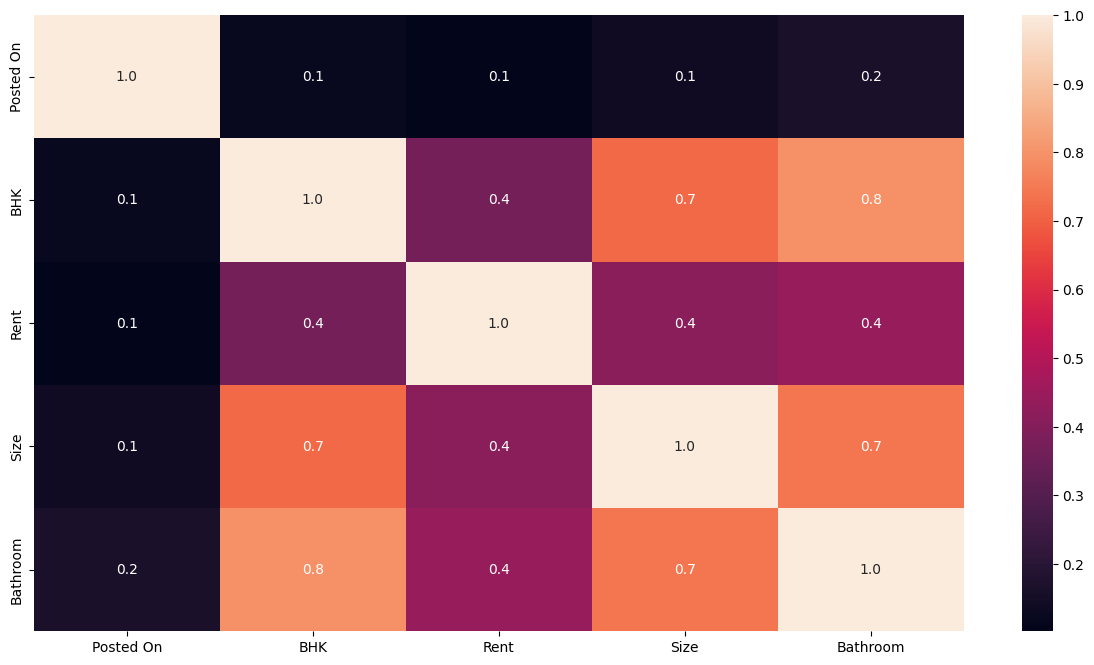

In [71]:
#посмотрим коррелирующие столбцы
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing

correlation = data.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=correlation, annot=True, fmt=".1f")


In [72]:
# больше всего кореллируют bathroom and BHK, size and bathroom, size and BHK. Удаляем BHK.
data = data.drop('BHK',axis = 1)

In [73]:
correlation[["Rent"]]

,Rent
Posted On,0.101925
BHK,0.369718
Rent,1.000000
Size,0.413551
Bathroom,0.441215


In [75]:
data.head()

,Posted On,Rent,Size,Area Type,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,5,10000,1100,Super Area,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,5,20000,800,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,5,17000,1000,Super Area,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,7,10000,800,Super Area,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,5,7500,850,Carpet Area,Kolkata,Unfurnished,Bachelors,1,Contact Owner


In [76]:
# переведем строковые значения в числовые
object_columns = data.select_dtypes(include='object')
object_columns_names = list(object_columns.columns)
print('Object columns', object_columns_names)

Object columns ['Area Type', 'City', 'Furnishing Status', 'Tenant Preferred', 'Point of Contact']


In [77]:
int_data = pd.get_dummies(data=data, prefix=['area', 'city', 'status', 'tenant', 'contract'], prefix_sep='_',
               columns = object_columns_names, drop_first =True,dtype='int8')
int_data.head()

,Posted On,Rent,Size,Bathroom,area_Carpet Area,area_Super Area,city_Chennai,city_Delhi,city_Hyderabad,city_Kolkata,city_Mumbai,status_Semi-Furnished,status_Unfurnished,tenant_Bachelors/Family,tenant_Family,contract_Contact Builder,contract_Contact Owner
0,5,10000,1100,2,0,1,0,0,0,1,0,0,1,1,0,0,1
1,5,20000,800,1,0,1,0,0,0,1,0,1,0,1,0,0,1
2,5,17000,1000,1,0,1,0,0,0,1,0,1,0,1,0,0,1
3,7,10000,800,1,0,1,0,0,0,1,0,0,1,1,0,0,1
4,5,7500,850,1,1,0,0,0,0,1,0,0,1,0,0,0,1


In [81]:
# полученные столбцы
int_all_columns_names = list(int_data.columns)
print(int_all_columns_names)

['Posted On', 'Rent', 'Size', 'Bathroom', 'area_Carpet Area', 'area_Super Area', 'city_Chennai', 'city_Delhi', 'city_Hyderabad', 'city_Kolkata', 'city_Mumbai', 'status_Semi-Furnished', 'status_Unfurnished', 'tenant_Bachelors/Family', 'tenant_Family', 'contract_Contact Builder', 'contract_Contact Owner']


In [82]:
from sklearn.model_selection import train_test_split

y = int_data['Rent']
x = int_data.drop('Rent',axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [97]:
# регрессия без регуляризации, вычисление псевдообратной матрицы
#добавляем к матрицам столбец из единиц
import numpy as np

x_train_0 = np.c_[np.ones((x_train.shape[0],1)),x_train]
x_test_0 = np.c_[np.ones((x_test.shape[0],1)),x_test]
theta = np.matmul(np.linalg.inv( np.matmul(x_train_0.T,x_train_0) ), np.matmul(x_train_0.T,y_train))
parameter = ['theta_'+str(i) for i in range(x_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(x.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

In [98]:
x_train_0

array([[1.00e+00, 5.00e+00, 9.50e+02, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [1.00e+00, 6.00e+00, 8.00e+02, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       [1.00e+00, 6.00e+00, 5.45e+02, ..., 0.00e+00, 0.00e+00, 1.00e+00],
       ...,
       [1.00e+00, 7.00e+00, 8.00e+02, ..., 1.00e+00, 0.00e+00, 0.00e+00],
       [1.00e+00, 5.00e+00, 3.50e+03, ..., 0.00e+00, 0.00e+00, 0.00e+00],
       [1.00e+00, 6.00e+00, 4.50e+02, ..., 0.00e+00, 0.00e+00, 0.00e+00]])

In [99]:
mse = np.sum((np.matmul(x_test_0, theta) - y_test)**2)/ x_test_0.shape[0]

sse = np.sum((np.matmul(x_test_0, theta) - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (sse/sst)
print('MSE: ', mse)
print('R2:', r2)

MSE:  1906593907.4009287
R2: 0.5216031401599318


In [100]:
# ипсользуя sklearn
linear_regression_model = LinearRegression()
linear_regression_model.fit(x_train,y_train)

theta = [linear_regression_model.intercept_]+list(linear_regression_model.coef_)
mse = np.sum((np.matmul(x_test_0, theta) - y_test)**2)/ x_test_0.shape[0]
sse = np.sum((np.matmul(x_test_0, theta) - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (sse/sst)
print('MSE: ', mse)
print('R2: ', r2)

MSE:  1906593907.400934
R2:  0.5216031401599306


In [101]:
parameter_df = parameter_df.join(pd.Series(theta, name='sklearn_lin_reg_theta'))
parameter_df.head()

,Parameter,Columns,theta,sklearn_lin_reg_theta
0,theta_0,intersect:x_0=1,-9182.672309,-9182.672309
1,theta_1,Posted On,-496.676125,-496.676125
2,theta_2,Size,37.870260,37.870260
3,theta_3,Bathroom,13721.506977,13721.506977
4,theta_4,area_Carpet Area,-6062.394001,-6062.394001


In [103]:
# регрессия с L2 регуляризацией
#добавляем к матрицам столбец из единиц

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_L2 = scaler.fit_transform(x_train)
x_test_L2 = scaler.transform(x_test)
x_train_L2 = np.c_[np.ones((x_train.shape[0],1)),x_train_L2]
x_test_L2 = np.c_[np.ones((x_test.shape[0],1)),x_test_L2]



In [105]:
alpha = 0.001 #коэффициент регуляризации

ridge_matrix = -alpha * np.eye(x_train.T.shape[0] + 1, k = -1)
ridge_matrix[0, 0] = 0
L2_coefs = np.matmul(np.linalg.inv(np.matmul(x_train_L2.T,x_train_L2) +  ridge_matrix), np.matmul(x_train_L2.T,y_train))
mse = np.sum((np.matmul(x_test_L2,L2_coefs) - y_test)**2)/ x_test_L2.shape[0]
sse = np.sum((np.matmul(x_test_L2,L2_coefs) - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (sse/sst)

print('MSE:', mse)
print('R2:', r2)


MSE: 1906594005.248881
R2: 0.5216031156082153


In [106]:
# используя sklearn
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

ridge = Ridge()
scaler = StandardScaler()
x_train_L2_Sk = scaler.fit_transform(x_train)
x_test_L2_Sk = scaler.transform(x_test)
ridge.alpha = alpha
ridge.fit(x_train_L2_Sk, y_train)
y_pred = ridge.predict(x_test_L2_Sk)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MSE:', mse)
print('R2:', r2)

MSE: 1906593987.6042495
R2: 0.5216031200355536


In [107]:
theta = [ridge.intercept_]+list(ridge.coef_)
parameter_df = parameter_df.join(pd.Series(theta, name='sklearn_l2_theta'))
parameter_df

,Parameter,Columns,theta,sklearn_lin_reg_theta,sklearn_l2_theta
0,theta_0,intersect:x_0=1,-9182.672309,-9182.672309,35151.516333
1,theta_1,Posted On,-496.676125,-496.676125,-415.007467
2,theta_2,Size,37.870260,37.870260,24049.915615
3,theta_3,Bathroom,13721.506977,13721.506977,12162.077842
4,theta_4,area_Carpet Area,-6062.394001,-6062.394001,-3028.611182
5,theta_5,area_Super Area,-9364.762277,-9364.762277,-4679.075213
6,theta_6,city_Chennai,-7506.653725,-7506.653725,-2938.223118
7,theta_7,city_Delhi,8028.792525,8028.792525,2689.643519
8,theta_8,city_Hyderabad,-16734.453936,-16734.453936,-6428.138036
9,theta_9,city_Kolkata,-1746.183532,-1746.183532,-539.670435


In [111]:
#градиентный спуск
x_train_b = scaler.fit_transform(x_train)
x_test_b = scaler.transform(x_test)
def gradient_descent(theta, X, y, learning_rate, iter):
    mse_list = []
    for _ in range(iter):
        gradient = 2/X.shape[0] * X.T.dot(X.dot(theta) - y_train.values.reshape(-1, 1))
        theta = theta - learning_rate * gradient
        mse = np.sum((X.dot(theta) - y.values.reshape(-1, 1))**2) / (2 * len(y))
        mse_list.append(mse)
    return theta, mse_list

#столбец единиц
x_train_b = np.c_[np.ones((x_train.shape[0], 1)), x_train_b]

theta = np.random.randn(17, 1)
learning_rate = 0.1
iter = 100
theta, mse_list = gradient_descent(theta, x_train_b, y_train, learning_rate, iter)
print("Theta:", theta.flatten())
x_test_b = np.c_[np.ones((x_test.shape[0], 1)), x_test_b]
mean_squared_log_error = np.sum((np.matmul(x_test_b, theta.flatten()) - y_test)**2)/ x_test_b.shape[0]
sse = np.sum((np.matmul(x_test_b, theta.flatten()) - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
r2 = 1 - (sse/sst)
print('MSE:', mse)
print('R2:', r2)

Theta: [35151.51632582  -419.04329398 23882.23248825 12323.55615332
   748.98876925  -897.95662105 -3020.86657612  2590.10096788
 -6501.87061619  -596.31470537 19728.9334506  -4286.79759816
 -3940.64907357  -280.7281709  -3306.62920676   381.54855849
 -4493.85144533]
MSE: 1906593987.6042495
R2: 0.5212563099509955


L2 регуляризация практически не влияет на качество модели, значения mse и r2 почти не меняются. Метод градиентного спуска также не показал значимых различий. Результаты почти идентичны.

In [133]:
# вес признаков
weights = dict()
for column in range(len(x.columns)):
  weights[x.columns[column]] = abs(linear_regression_model.coef_[column])
sorted_dict_amount = sorted(weights.items(), key=lambda x:x[1], reverse=True)
print(sorted_dict_amount)


[('city_Mumbai', 49391.58360025999), ('contract_Contact Builder', 23623.89492366692), ('city_Hyderabad', 16734.45393609959), ('Bathroom', 13721.506977142571), ('tenant_Family', 11129.699394886664), ('contract_Contact Owner', 9511.104604566319), ('area_Super Area', 9364.762276828444), ('status_Semi-Furnished', 8523.422297030314), ('status_Unfurnished', 8081.985576668217), ('city_Delhi', 8028.792524830609), ('city_Chennai', 7506.653724655214), ('area_Carpet Area', 6062.394000672942), ('city_Kolkata', 1746.1835315642554), ('tenant_Bachelors/Family', 649.5749012122429), ('Posted On', 496.6761251764947), ('Size', 37.87025962507789)]


Наибольшее влияние на размер аренды имеют город, количество ванных комнат.